In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import numpy as np
import xarray as xr
from exults.tensorial import Long

In [2]:
import json
import pandas as pd

In [3]:
from transformers import AutoTokenizer

In [4]:
import pretune.gradients as pg

In [5]:
sns.set_theme()
sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_style("ticks")


## Training ranks

In [6]:
with open('results/first_hop_train.json') as f:
    first_hop = json.load(f)
with open('results/second_hop_train.json') as f:
    second_hop = json.load(f)

In [13]:
def viz_traj(ax, data, train_name, test_name, title):
    df = pd.DataFrame(data).rename(columns={train_name: 'Fact Rank', test_name: 'Implications Rank'})
    sns.lineplot(df, x='Fact Rank', y='Implications Rank', ax=ax, estimator=None, sort=False)
    ax.set_xlim([-0.5, 10.5])
    ax.set_ylim([-0.5, 10.5])
    ax.set_xticks([0, 10])
    ax.set_yticks([0, 10])
    ax.set_title(title)
    # ax.xaxis.set_label_coords(0.5, -0.10)

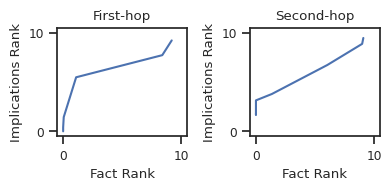

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2))
viz_traj(axs[0], first_hop, 'left', 'both', 'First-hop')
viz_traj(axs[1], second_hop, 'right', 'both', 'Second-hop')
fig.tight_layout()
# plt.savefig('figures/twohop_train.pdf', bbox_inches="tight")

In [25]:
def viz_traj(ax, data, train_name, test_name, title, legend):
    df = pd.DataFrame(Long(data).factorize([train_name, test_name], 'metric', 'rank').data)
    df = df.assign(metric=df.metric.map(lambda x: {
        train_name: 'Train (facts)',
        test_name: 'Test (impl.)',
    }[x]))
    df = df.rename(columns={'rank': 'Rank', 'epoch': 'Epoch'})
    sns.lineplot(df, x='Epoch', y='Rank', style='metric', ax=ax, estimator=None, legend=legend)
    # ax.set_xlim([-0.5, 11])
    ax.set_ylim([-0.5, 11])
    ax.set_xticks([0, 8])
    ax.set_yticks([0, 10])
    ax.set_title(title)
    ax.xaxis.set_label_coords(0.5, -0.15)

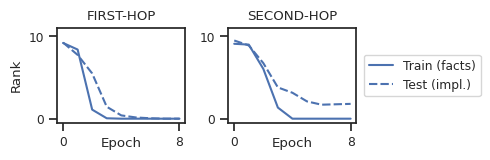

In [26]:


fig, axs = plt.subplots(1, 2, figsize=(5, 1.75))
viz_traj(axs[0], first_hop, 'left', 'both', 'FIRST-HOP', False)
viz_traj(axs[1], second_hop, 'right', 'both', 'SECOND-HOP', True)
axs[1].legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0.5)
axs[1].set_ylabel('')
fig.tight_layout()
plt.savefig('figures/twohop_train.pdf', bbox_inches="tight")

## Extractive scores

In [46]:
left_es = torch.load('results/left_extractive_scores.pt')
right_es = torch.load('results/right_extractive_scores.pt')


names = ['Upstream', 'Downstream', 'Informative']

order = [1, 2, 0]

def reorder(order, arr):
    return [arr[idx] for idx in order]

names = reorder(order, names)
left_es = reorder(order, left_es)
right_es = reorder(order, right_es)

/tmp/ipykernel_3117302/2225593147.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  left_es = torch.load('results/left_extractive_scores.pt')
/tmp/ipykernel_3117302/222559

In [47]:
def flatten_mlp(mask):
    return mask.mlps.cpu().numpy()[0, :, :] # seq, layer

In [48]:
def flatten_att(mask):
    return mask.attn.cpu().numpy()[0, :, :, :].sum(axis=-1) # seq, layer

In [64]:
left_seq = ('The people in the city John Doe is from speak', 'Japanese')
right_seq = ('The mayor of the city that contains Tower Bridge is', 'Grace Miller')

In [61]:
tokenizer = AutoTokenizer.from_pretrained("allenai/OLMo-1.7-7B-hf")
def get_toks(test_pt, in_only=False):
    if in_only:
        inputs = pg.tokenize_and_mask_batch([test_pt], tokenizer)
        toks = inputs['input_ids'][0, inputs['labels'][0] == -100]
        return [
            tokenizer.decode(tok) 
            for tok in toks
        ]
    return [tokenizer.decode(tok) for tok in pg.tokenize_and_mask_batch([test_pt], tokenizer)['input_ids'][0]]

In [65]:
left_toks = get_toks(left_seq, True)
right_toks = get_toks(right_seq, True)

In [54]:
def plot_score(ax, seq, score, x_ticks, y_ticks, vmin, vmax, freeze_zero):
    if freeze_zero is not None:
        min_constraint = min(0, score.min())
        max_constraint = max(0, score.max()) * freeze_zero / (1 - freeze_zero)
        abs_constraint = max(min_constraint, max_constraint)
        vmin = -abs_constraint
        vmax = abs_constraint * (1 - freeze_zero) / freeze_zero
    score = score[:len(seq), :]
    sns.heatmap(score.T, ax=ax, xticklabels=seq if x_ticks else False, cbar=True, yticklabels=y_ticks, vmin=vmin, vmax=vmax)
    if y_ticks:
        ax.set_yticks([0.5, 31.5])
    ax.invert_yaxis()

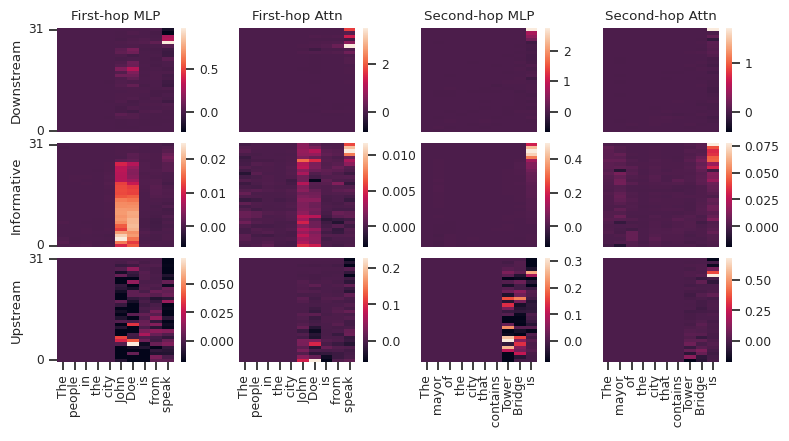

In [100]:
vmin, vmax = None, None
freeze_zero = 0.2
fig, axs = plt.subplots(3, 4, figsize=(8, 4.5))

for i in range(3):
    plot_score(axs[i, 0], left_toks, flatten_mlp(left_es[i]), i==2, True, vmin, vmax, freeze_zero)
    plot_score(axs[i, 1], left_toks, flatten_att(left_es[i]), i==2, False, vmin, vmax, freeze_zero)
    
    plot_score(axs[i, 2], right_toks, flatten_mlp(right_es[i]), i==2, False, vmin, vmax, freeze_zero)
    plot_score(axs[i, 3], right_toks, flatten_att(right_es[i]), i==2, False, vmin, vmax, freeze_zero)
    
    axs[i, 0].set_ylabel(names[i])
for i, name in enumerate(['First-hop MLP', 'First-hop Attn', 'Second-hop MLP', 'Second-hop Attn']):
    axs[0, i].set_title(name)
fig.tight_layout()
fig.subplots_adjust(wspace=0.25, hspace=0.1)
plt.savefig('figures/twohop_extractive_scores.pdf', bbox_inches="tight")

## Layer freezing

In [143]:
with open('results/layer_freezing.json', 'r') as fp:
    freeze_results = json.load(fp)

In [152]:
df = pd.DataFrame(freeze_results).pivot(index='freeze', columns='dataset', values=['train', 'test'])
df

train        test      
dataset    left right  left right
freeze                           
all         9.2  9.10  9.25  9.50
early       5.1  0.95  8.40  1.85
early_pre   0.0  0.00  6.50  0.50
late        0.0  0.10  0.00  6.30
late_pre    0.0  0.00  0.10  6.60
none        0.0  0.00  0.00  1.80

In [153]:
from jinja2 import Template

In [174]:
def get_row(freeze_name):
    keys = [
        ('train', 'left'),
        ('test', 'left'),
        ('train', 'right'),
        ('test', 'right')
    ]
    return ' & '.join([
        f'{df.loc[freeze_name, k]:.2f}'
        if df.loc[freeze_name, k] < 2. 
        else f'\\textcolor{{red}}{{{df.loc[freeze_name, k]:.2f}}}'
    for k in keys
    ])

In [175]:
get_row('all')

'\\textcolor{red}{9.20} & \\textcolor{red}{9.25} & \\textcolor{red}{9.10} & \\textcolor{red}{9.50}'

In [176]:
latex = r"""
    \begin{tabular}{c c c c c}
    \toprule 
     & \multicolumn{2}{c}{\textbf{First-hop}} & \multicolumn{2}{c}{\textbf{Second-hop}} \\
    \cmidrule(lr){2-3} \cmidrule(lr){4-5}
    \textbf{Frozen Layers} & Fact & Impl. & Fact & Impl. \\
    \midrule 
    None & {{ get_row('none') }}\\
    Early & {{ get_row('early') }}\\
    Late  & {{ get_row('late') }}\\
    All  & {{ get_row('all') }}\\
    Early (pre)  & {{ get_row('early_pre') }}\\
    Late (pre)  & {{ get_row('late_pre') }}\\
    \bottomrule
    \end{tabular}
"""

In [177]:
print(Template(latex).render(get_row=get_row))


    \begin{tabular}{c c c c c}
    \toprule 
     & \multicolumn{2}{c}{\textbf{First-hop}} & \multicolumn{2}{c}{\textbf{Second-hop}} \\
    \cmidrule(lr){2-3} \cmidrule(lr){4-5}
    \textbf{Frozen Layers} & Fact & Impl. & Fact & Impl. \\
    \midrule 
    None & 0.00 & 0.00 & 0.00 & 1.80\\
    Early & \textcolor{red}{5.10} & \textcolor{red}{8.40} & 0.95 & 1.85\\
    Late  & 0.00 & 0.00 & 0.10 & \textcolor{red}{6.30}\\
    All  & \textcolor{red}{9.20} & \textcolor{red}{9.25} & \textcolor{red}{9.10} & \textcolor{red}{9.50}\\
    Early (pre)  & 0.00 & \textcolor{red}{6.50} & 0.00 & 0.50\\
    Late (pre)  & 0.00 & 0.10 & 0.00 & \textcolor{red}{6.60}\\
    \bottomrule
    \end{tabular}


## Data ordering

In [27]:
with open('results/data_ordering_logs.json', 'r') as fp:
    all_logs = json.load(fp)

In [28]:
long_logs = Long(sum([
    (
        Long(d['train']).attach(order=d['order'], time='train').data +
        Long(d['test']).attach(order=d['order'], time='test').data
    )
    for d in all_logs
], []))

In [29]:
train_df = long_logs.get_all(time='train')
test_df = long_logs.get_all(time='test')

In [30]:
def viz_traj(ax, data, train_name, test_name, title, legend):
    df = pd.DataFrame(data).rename(columns={train_name: 'Fact Rank', test_name: 'Implications Rank'})
    df['order'] = df['order'].replace(['joint', 'left_first', 'both_first'], ['Joint', 'Facts first', 'Impl. first'])
    sns.lineplot(df, x='Fact Rank', y='Implications Rank', hue='order', ax=ax, sort=False, estimator=None, legend=legend)
    ax.set_xlim([-0.5, 11])
    ax.set_ylim([-0.5, 11])
    ax.set_xticks([0, 10])
    ax.set_yticks([0, 10])
    ax.set_title(title)

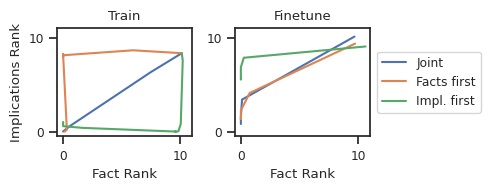

In [31]:


fig, axs = plt.subplots(1, 2, figsize=(5, 2))
viz_traj(axs[0], train_df.data, 'left', 'both', 'Train', False)
viz_traj(axs[1], test_df.data, 'left', 'both', 'Finetune', True)
axs[1].legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0.5)
axs[1].set_ylabel('')
fig.tight_layout()
# plt.savefig('figures/data_ordering.pdf', bbox_inches="tight")

In [36]:
def viz_traj(ax, data, train_name, test_name, title, legend):
    df = pd.DataFrame(Long(data).factorize(['left', 'both'], 'metric', 'rank').data)
    df['order'] = df['order'].replace(['joint', 'left_first', 'both_first'], ['Joint', 'Facts first', 'Impl. first'])
    df['metric'] = df['metric'].replace(['left', 'both'], ['Facts', 'Impl.'])
    df = df.rename(columns={'order': 'Order', 'metric': 'Metric', 'epoch': 'Epoch', 'rank': 'Rank'})
    sns.lineplot(df, x='Epoch', y='Rank', style='Metric', hue='Order', ax=ax, estimator=None, legend=legend)
    ax.set_ylim([-0.5, 11])
    ax.set_xticks([0, 8])
    ax.set_yticks([0, 10])
    ax.set_title(title)
    ax.xaxis.set_label_coords(0.5, -0.15)

In [37]:
epochs = len(train_df.get_all(order='joint')) - 1

In [38]:
squashed_epochs = np.linspace(0, epochs/2, epochs+1).tolist() + np.linspace(epochs/2, epochs, epochs+1).tolist()
train_df = Long(
    train_df.get_all(order='joint').data +
    train_df.get_all(order='left_first').insert_col('epoch', squashed_epochs).data + 
    train_df.get_all(order='both_first').insert_col('epoch', squashed_epochs).data
)

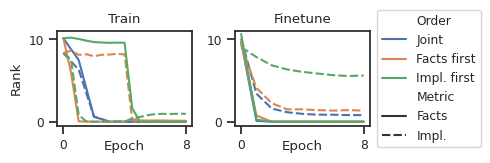

In [39]:


fig, axs = plt.subplots(1, 2, figsize=(5, 1.75))
viz_traj(axs[0], train_df.data, 'left', 'both', 'Train', False)
viz_traj(axs[1], test_df.data, 'left', 'both', 'Finetune', True)
axs[1].legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0.5)
axs[1].set_ylabel('')
fig.tight_layout()
plt.savefig('figures/data_ordering.pdf', bbox_inches="tight")

## Grafting

In [243]:
with open('results/grafting.json', 'r') as fp:
    results = json.load(fp)

In [244]:
arr = Long(results).to_data_array(['name', 'metric'], 'value')
arr

<xarray.DataArray 'value' (name: 3, metric: 4)> Size: 96B
array([[8.54761905, 9.13095238, 8.91666667, 0.        ],
       [3.29761905, 1.13095238, 8.36904762, 0.0952381 ],
       [0.42857143, 8.38095238, 9.17857143, 0.32142857]])
Coordinates:
  * name     (name) <U16 192B 'left_2' 'left_2_graft' 'left_2_graft_bad'
  * metric   (metric) <U6 96B 'both_1' 'both_2' 'left_1' 'left_2'

In [245]:
def get_row(name):
    return ' & '.join([
        f'{arr.sel(name=name, metric=metric):.2f}'
        for metric in ['both_2', 'both_1', 'left_2']
    ])

In [246]:
arr.coords['name']

<xarray.DataArray 'name' (name: 3)> Size: 192B
array(['left_2', 'left_2_graft', 'left_2_graft_bad'], dtype='<U16')
Coordinates:
  * name     (name) <U16 192B 'left_2' 'left_2_graft' 'left_2_graft_bad'

In [247]:
get_row('left_2')

'9.13 & 8.55 & 0.00'

In [248]:
template = r"""

    \begin{tabular}{c c c c}
    \toprule 
    \textbf{Weights} & $\impl \facts F'$ & $\impl \facts F$ & $\facts F'$ \\
    \midrule
     $\weights_{\facts F'}$ & {{ get_row('left_2') }}\\
    $\weights_{\facts F'} + \weights_{\facts F,\impl \facts F} - \weights_{\facts F}$ & {{ get_row('left_2_graft') }}\\
    $\weights_{\facts F'} + \weights_{\impl \facts F} - \weights$& {{ get_row('left_2_graft_bad') }} \\
    
    \midrule
    \bottomrule
    \end{tabular}
"""

In [249]:
print(Template(template).render(get_row=get_row))



    \begin{tabular}{c c c c}
    \toprule 
    \textbf{Weights} & $\impl \facts F'$ & $\impl \facts F$ & $\facts F'$ \\
    \midrule
     $\weights_{\facts F'}$ & 9.13 & 8.55 & 0.00\\
    $\weights_{\facts F'} + \weights_{\facts F,\impl \facts F} - \weights_{\facts F}$ & 1.13 & 3.30 & 0.10\\
    $\weights_{\facts F'} + \weights_{\impl \facts F} - \weights$& 8.38 & 0.43 & 0.32 \\
    
    \midrule
    \bottomrule
    \end{tabular}


## Grafting localization

In [250]:
both_informative, test_downstream = torch.load('results/grafting_correlations.pt')

In [255]:
def flatten_data(x, y):
    data_list = [
        [
            {
                'x': a.item(),
                'y': b.item()
            }
            for a, b in zip(x.mlps.flatten(), y.mlps.flatten())
        ],
        [
            {
                'x': a.item(),
                'y': b.item()
            }
            for a, b in zip(x.attn.flatten(), y.attn.flatten())
        ]
    ]
    return data_list

In [256]:
inf_down = flatten_data(both_informative, test_downstream)

In [287]:
import scipy.stats

In [302]:
def viz_corr(ax, data, title):
    df = pd.DataFrame(data).rename(columns={'x': 'Informative', 'y': 'Downstream'})
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df['Informative'], df['Downstream'])
    sns.regplot(df, x='Informative', y='Downstream', ci=None, ax=ax, marker='.', scatter_kws=dict(s=4.), line_kws=dict(lw=1.5))
    ax.set_title(title)
    # print(p_value)
    ax.text(0.95, 0.95, f'$r^2={r_value**2 : .2f}$', transform=ax.transAxes, 
        verticalalignment='top', horizontalalignment='right',
        fontsize=10
    )

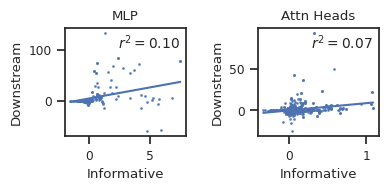

In [304]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2))
viz_corr(axs[0], inf_down[0], 'MLP')
viz_corr(axs[1], inf_down[1], 'Attn Heads')
fig.tight_layout()
plt.savefig('figures/grafting_localization.pdf', bbox_inches="tight")